In [1]:
import os
import keras
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
!nvidia-smi

Sun Feb 16 02:06:29 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.48.02    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [3]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 145113 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.17-0ubuntu2~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.17-0ubuntu2~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.17-0ubuntu2~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
import os
os.chdir("drive/Deep learning in python") 

In [6]:
!ls

 6_2_advanced_used_rnn.ipynb			  aclImdb
 6_2_rnn.ipynb					  aclImdb.zip
'6-Deep learning for text  and sequences.ipynb'   jena_climate_2009_2016.csv


In [0]:
'''
读取文件，并且对文件进行处理
'''
f = open('jena_climate_2009_2016.csv')
data = f.read()
f.close()
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

In [8]:
header

['"Date Time"',
 '"p (mbar)"',
 '"T (degC)"',
 '"Tpot (K)"',
 '"Tdew (degC)"',
 '"rh (%)"',
 '"VPmax (mbar)"',
 '"VPact (mbar)"',
 '"VPdef (mbar)"',
 '"sh (g/kg)"',
 '"H2OC (mmol/mol)"',
 '"rho (g/m**3)"',
 '"wv (m/s)"',
 '"max. wv (m/s)"',
 '"wd (deg)"']

In [9]:
len(lines)

420551

In [17]:
len(header)

15

In [0]:
'''
6-29解析数据
'''
float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
  values = [float(x) for x in line.split(',')[1:]]
  float_data[i, :] = values

In [20]:
float_data

array([[ 0.90014748, -1.93135845, -1.98211036, ..., -0.72950452,
        -0.78067973, -0.27613603],
       [ 0.9060434 , -1.97541381, -2.02567   , ..., -0.93124017,
        -0.88794488, -0.46317443],
       [ 0.90132666, -1.98671006, -2.03683914, ..., -1.27614304,
        -1.26122763, -0.05330633],
       ...,
       [ 1.28927851, -1.38236094, -1.46721307, ..., -0.69696652,
        -0.67341457,  0.45008097],
       [ 1.28809932, -1.50323076, -1.58672285, ..., -0.43015486,
        -0.60476487,  0.57246412],
       [ 1.28927851, -1.56987861, -1.65150386, ..., -0.5993525 ,
        -0.690577  ,  0.10024989]])

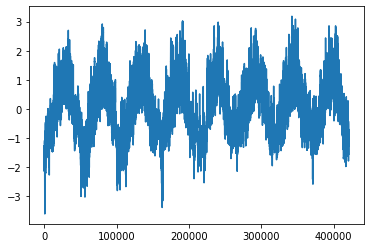

In [15]:
'''
6-30绘制温度时间序列
'''
temp = float_data[:, 1]
plt.plot(range(len(temp)), temp)

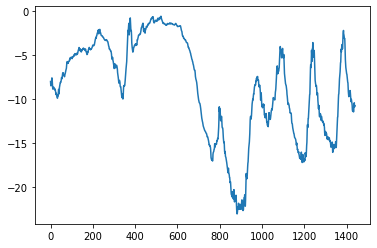

In [12]:
'''
6-31绘制前10天的温度时间序列
'''
plt.plot(range(1440), temp[:1440])

In [0]:
'''
6-32数据标准化
'''
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [0]:
'''
6-33生成时间序列样本及其目标的生成器
参数:
data:浮点数数据组成的原始数组，已经标准化
lookback:输入数据应该包括过去多少个时间步
delay:目标应该在未来多少个时间步之后
min_index和max_index:data数组中的索引，用于界定需要抽取哪些时间步。这有助于保存一部分数据用于验证，另一部分用于测试
shuffle:是打乱样本，还是按照顺序抽取样本
batch_size:每个批量的样本数
step:数据采样的周期（单位：时间步）。我们将其设为6，为的是每小时抽取一个数据点
'''

def generator(data, lookback, delay, min_index, max_index,
        shuffle=False, batch_size=128, step=6):
  if max_index is None:
    max_index = len(data) - delay - 1
  i = min_index + lookback
  while 1:
    if shuffle:
      rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
    else:
      if i + batch_size >= max_index:
        i = min_index + lookback
      rows = np.arange(i, min(i + batch_size, max_index))
      i += len(rows)
    
    samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
    targets = np.zeros((len(rows),))
    for j, row in enumerate(rows):
      indices = range(rows[j] - lookback, rows[j], step)
      samples[j] = data[indices]
      targets[j] = data[rows[j] + delay][1]
    yield samples, targets


In [0]:
'''
6-34准备训练生成器，验证生成器和测试生成器
'''
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data, lookback=lookback, delay=delay, min_index=0, max_index=200000, shuffle=True, step=step, batch_size=batch_size)
val_gen = generator(float_data, lookback=lookback, delay=delay, min_index=200001, max_index=300000, shuffle=True, step=step, batch_size=batch_size)
test_gen = generator(float_data, lookback=lookback, delay=delay, min_index=300001, max_index=None, shuffle=True, step=step, batch_size=batch_size)


In [0]:
#为了查看验证集，需要从val_gen中抽取多少次
val_steps = (300000 - 200001 - lookback) // batch_size

#为了查看整个测试集，需要从test_gen中抽取多少次
test_steps = (len(float_data) - 300001 - lookback) // batch_size

In [26]:
val_steps

769

In [27]:
test_steps

930

In [29]:
'''
6-35计算符合常识的基准方法的MAE
'''
def evaluate_naive_method():
  batch_maes = []
  for step in range(val_steps):
    samples, targets = next(val_gen)
    preds = samples[:, -1, 1]
    mae = np.mean(np.abs(preds - targets))
    batch_maes.append(mae)
  print(np.mean(batch_maes))

evaluate_naive_method()

0.2906303355744416
